# ThemeParkBot

This ThemeParkBot is designed to help the management and creative decisions about the theme park, suggesting which type of attractions are most popular, which attractions are a net loss and should be replaced and so on...

### Install SDK

In [1]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'google-genai==1.7.0' 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' 'graphviz'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 9.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.12 requires async-t

In [2]:
#import section
from google import genai
from google.genai import types
from google.api_core import retry
from IPython.display import HTML, Markdown, display, Image
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.tools import tool



import sqlite3
import os
import google.api_core.exceptions

genai.__version__

'1.7.0'

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

Setting environmental variable to enable the chatobot llm capabilities

In [4]:
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

**Automated** flag:
* Set it set to **True** if you want to automatically run the notebook
* Set it to **False** if you want to manually enter the questions for the AI agent

In [5]:
AUTOMATED = True

In [6]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Database definition
Using _IPython magic commands_ to creare and populare a sqlite database

In [7]:
%load_ext sql
%sql sqlite:///ThemePark.db

Define and populare tables
<br><br>Edit as desired to enable the llm to perform deeper analysis

In [8]:
%%sql
-- Create the 'Land' table
CREATE TABLE IF NOT EXISTS Land (
  	LandId INTEGER PRIMARY KEY AUTOINCREMENT,
  	LandName VARCHAR(255) NOT NULL,
  	LandArea DECIMAL(10, 2) NOT NULL
  );

-- Create the 'AttractionType' table
CREATE TABLE IF NOT EXISTS AttractionType (
  	AttractionTypeId INTEGER PRIMARY KEY AUTOINCREMENT,
  	AttractionType VARCHAR(255) NOT NULL  	
  );

-- Create the 'Attraction' table
CREATE TABLE IF NOT EXISTS Attraction (
  	AttractionId INTEGER PRIMARY KEY AUTOINCREMENT,
  	Attraction VARCHAR(255) NOT NULL,
  	AttractionTypeId INTEGER NOT NULL,
  	LandId INTEGER NOT NULL,
  	FOREIGN KEY (AttractionTypeId) REFERENCES AttractionType (AttractionTypeId),
    FOREIGN KEY (LandId) REFERENCES Land (LandId)
  );

-- Create the 'AttractionPerYear' table
CREATE TABLE IF NOT EXISTS AttractionPerYear (
  	AttractionPerYearId INTEGER PRIMARY KEY AUTOINCREMENT,
    AttractionId INTEGER,
  	Year INTEGER NOT NULL,
    Revenue DECIMAL(12, 2) NOT NULL,
  	Costs DECIMAL(12, 2) NOT NULL,
    Guests INTEGER NOT NULL DEFAULT 0,
  	IsOperational BOOLEAN NOT NULL DEFAULT 1,
  	FOREIGN KEY (AttractionId) REFERENCES Attraction (AttractionId)
  );

INSERT INTO Land (LandName, LandArea)
SELECT * FROM (
  SELECT 'Adventure' AS LandName, 12.50 AS LandArea
  UNION ALL
  SELECT 'Fantasy', 9.75
  UNION ALL
  SELECT 'Steampunk', 14.30
) AS new_lands
WHERE NOT EXISTS (
  SELECT 1 FROM Land WHERE LandName = new_lands.LandName
);

-- Insert into AttractionType
INSERT INTO AttractionType (AttractionType)
SELECT * FROM (
  SELECT 'Roller Coaster' AS AttractionType
  UNION ALL
  SELECT 'Water Ride'
  UNION ALL
  SELECT 'Dark Ride'
) AS new_attraction_types
WHERE NOT EXISTS (
  SELECT 1 FROM AttractionType WHERE AttractionType = 'Roller Coaster'
);

-- Insert into Attraction
INSERT INTO Attraction (Attraction, AttractionTypeId, LandId)
SELECT * FROM (
  SELECT 'Ghost House' AS Attraction, 3 AS AttractionTypeId, 2 AS LandId
  UNION ALL
  SELECT 'Splash Zone', 2, 1
  UNION ALL
  SELECT 'Space Voyage', 1, 3
) AS new_attractions
WHERE NOT EXISTS (
  SELECT 1 FROM Attraction WHERE Attraction = 'Ghost House'
);

-- Insert into AttractionPerYear
INSERT INTO AttractionPerYear (AttractionId, Year, Revenue, Costs, Guests, IsOperational)
SELECT * FROM (
  SELECT 1 AS AttractionId, 2024 AS Year, 1200000.00 AS Revenue, 450000.00 AS Costs, 250000 AS Guests, 1 AS IsOperational
  UNION ALL
  SELECT 2, 2024, 9800.00, 300000.00, 1800, 1
  UNION ALL
  SELECT 3, 2024, 750000.00, 270000.00, 120000, 1
  UNION ALL
  SELECT 1, 2023, 120000.00, 450000.00, 250000, 1
  UNION ALL
  SELECT 2, 2023, 98000.00, 300000.00, 18000, 1
  UNION ALL
  SELECT 3, 2023, 75000.00, 270000.00, 12000, 1
  UNION ALL
  SELECT 1, 2022, 12000.00, 450000.00, 25000, 1
  UNION ALL
  SELECT 2, 2022, 980000.00, 300000.00, 180000, 1
  UNION ALL
  SELECT 3, 2022, 7500.00, 270000.00, 1200, 1
) AS new_attraction_per_year
WHERE NOT EXISTS (
  SELECT 1 FROM AttractionPerYear WHERE AttractionId = 1 AND Year = 2024
);



 * sqlite:///ThemePark.db
Done.
Done.
Done.
Done.
3 rows affected.
3 rows affected.
3 rows affected.
9 rows affected.


[]

# Database functions

In [9]:
db_file = "ThemePark.db"
db_conn = sqlite3.connect(db_file)

# AI Agent

Building a new LangGraph graph
1. AnalysisState - State object, acts as the shared memory of the graph
2. ASSISTANT_SYSINT - Define the system initial prompt, this defines the key behaviour of the chatbot
3. Nodes - Define the nodes, functions that take the State as an input and return an updated State as an output
4. Edges - Define the edges, they indicate the transition of the State between two nodes
5. Conditional Edges - Conditional edges route the State between different routes dinamically
6. Tools - Tools are functions callable by the chatbot itself

In [10]:
#create state containing message history and a boolean to flag the end of the conversation 
class AnalysisState(TypedDict):
    """State representing the analyst conversation with the chatbot."""

    # The chat conversation. 
    # The state is updated by appending returned messages, not replacing them.
    messages: Annotated[list, add_messages]

    # Flag indicating the chat is concluded.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes rules for when to call different functions, 
# tone of the conversation and so on
ASSISTANT_SYSINT = (
    "system",
    "You are ThemeParkAssistan, an AI assistant helping data analysts make informed decisions based on a SQLite database from the theme park 'Legendary Galaxy'.\n\n"
    
    "**Your behaviour rules:**\n"
    "- NEVER assume table or field names. NEVER guess them based on intuition.\n"
    "- You MUST use `list_tables()` before referencing any table in a query.\n"
    "- Before using any field or column, use `describe_table()` to learn about that table's schema.\n"
    "- NEVER mention or ask the user about table names, columns, or SQL directly. If something is missing, troubleshoot using the tools.\n"
    "- If you cannot find a table or column, explain what you tried and stop. DO NOT ask the user about it.\n"
    "- Think step by step: first list the tables, then explore a table's structure, then run a query if needed.\n"
    "- You can also access the web through the 'search_web()' tool when the answer is not available from the database or your own knowledge.\n"
    "- **If you're not confident in your own knowledge or the database does not provide sufficient information, search the web immediately**.\n"
    "- Web search should be the **first** option if you suspect the information is outside of the database or your training knowledge, **not just a last resort**.\n"
    "- If you use the web, **be sure to clarify that the answer came from an online search** and provide a source if possible.\n"
    "- When asked about time periods (yesterday, last year, and so on) always go search the web to know what time are they refferring to.\n"
    "- Your job is to answer the user's business question clearly and then suggest a useful follow-up.\n"
    "- Don't write 'A useful follow-up would be to'—be more subtle in suggesting follow-ups."
)

WELCOME_MSG = "Welcome from ThemeParkAssistan. Type `quit` to quit. How may I help you?"

### Tools
Tools for DB access

In [11]:
@tool
def query_db(query: str) -> list[list[str]]:
    """Run a sqlite query and reuturn the results"""
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    try:
        cursor.execute(query)
        result = cursor.fetchall()
    except Exception as e:
        result = f"Error: {e}"
    finally:
        conn.close()
        
    return result

@tool
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    try:
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        result = [row[0] for row in tables]
    except Exception as e:
        result = f"Error: {e}"
    finally:
        conn.close()
        
    return result

@tool
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.
    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    try:
        cursor.execute(f"PRAGMA table_info({table_name});")
        schema = cursor.fetchall()
        result = [(col[1], col[2]) for col in schema]
    except Exception as e:
        result = f"Error: {e}"
    finally:
        conn.close()
        
    return result

Tools for web access

In [12]:
# Create the Gemini model with web search grounding
search_tool = types.Tool(google_search=types.GoogleSearch())
config_with_search = types.GenerateContentConfig(tools=[search_tool])

@tool
def search_web(query: str) -> str:
    """Use Gemini's grounded web search to retrieve current information for a query."""
    try:
        response = client.models.generate_content(
            model='gemini-2.0-flash',
            contents=query,
            config=config_with_search,
        )
        # Extract and return the textual answer
        result_text = response.text.strip()
        if not result_text:
            return "I searched the web but couldn't find a clear answer to that."
        return result_text

    except google.api_core.exceptions.GoogleAPIError as e:
        return f"Web search failed due to a network or API error: {e}"

    except Exception as e:
        return f"An unexpected error occurred during web search: {e}"

Define llm, associate tools (db tools and web tools), create node functions and conditional edges

In [13]:
#define the node tools to associate to the llm
tools = [query_db, list_tables, describe_table]
tool_node = ToolNode(tools)

web_tools = [search_web]
web_tool_node = ToolNode(web_tools)

#select the model for the chatbot
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_w_tools = llm.bind_tools(tools + web_tools)

To enable automated run on kaggle two different human nodes have been created:
* **manual_human_node** - allows direct interaction between chatgpt and user
* **automated_human_node** - simulates the chatbot - user interaction with predefined questions

In [14]:
automated_inputs = iter([
    "What was the most popular attraction by number of guests in our park last?",
    "Make a numbered list of all our attractions by profit last year",
    "Make a numbered Top 10 list of the most popular brands last year from movies, video games and books",
    "quit"
])

#create nodes
def manual_human_node(state: AnalysisState) -> AnalysisState:
    msg = state["messages"][-1]
    if msg.content != WELCOME_MSG:
        msg.content = "<br>" + msg.content
        
    display(Markdown(msg.content))

    user_input = input("> ")

    if user_input in {"q", "quit", "exit"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

def automated_human_node(state):
    msg = state["messages"][-1]
    if msg.content != WELCOME_MSG:
        msg.content = "<br>" + msg.content
        
    display(Markdown(msg.content))
    
    try:
        user_input = next(automated_inputs)
        print(f"[AUTOMATED INPUT] {user_input}")
    except StopIteration:
        user_input = "quit"
        state["finished"] = True
    return state | {"messages": [("user", user_input)]}

def chatbot_w_tools(state: AnalysisState) -> AnalysisState:
    """chatbot node with added tool functionalities"""
    #defaults = {finished: False}

    if state["messages"]:
        output = llm_w_tools.invoke([ASSISTANT_SYSINT] + state["messages"])
    else:
        output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [output]}

#create conditional edge
def evaluate_exit(state: AnalysisState) -> Literal["chatbot", "__end__"]:
    if state.get("finished", False):
        return END
    else:
        return "chatbot"
    
def evaluate_tool_use(state: AnalysisState) -> Literal["tools", "web", "human"]:
    """if the llm choose to call a tool function go to tool node, otherwise back to human node"""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        tool_name = msg.tool_calls[0]["name"]
        if tool_name == "search_web":
            return "web"
        else:
            return "tools"
    else:
        return "human"


__Build the graph__ based on State, Nodes, Edges and ConditionalEdges created

In [15]:
#Build graph
graph_builder = StateGraph(AnalysisState)

#create nodes and link them to their function
graph_builder.add_node("chatbot", chatbot_w_tools)
#graph_builder.add_node("human", human_node)
graph_builder.add_node("human", manual_human_node if not AUTOMATED else automated_human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("web", web_tool_node)

#add conditional edges to chatbot and human nodes
graph_builder.add_conditional_edges("chatbot", evaluate_tool_use)
graph_builder.add_conditional_edges("human", evaluate_exit)

#add fixed edges to nodes
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("web", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph_w_tools = graph_builder.compile()

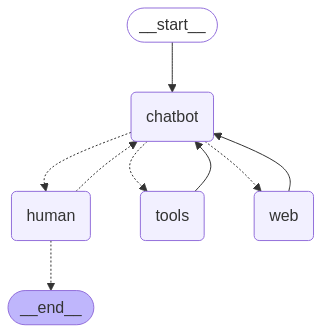

In [16]:
#visual rapresentation of the graph
Image(graph_w_tools.get_graph().draw_mermaid_png())    

In [17]:
#set custom recursion limit to traverse nodes
config = {"recursion_limit": 50}

#run the chatbot
state = graph_w_tools.invoke({"messages": []}, config)

Welcome from ThemeParkAssistan. Type `quit` to quit. How may I help you?

[AUTOMATED INPUT] What was the most popular attraction by number of guests in our park last?


<br>The most popular attraction last year (2024) was Ghost House.

You could ask me to compare the popularity of different attractions over multiple years.

[AUTOMATED INPUT] Make a numbered list of all our attractions by profit last year


<br>Here are the attractions ranked by profit for last year (2024):

1.  Ghost House: 750000
2.  Space Voyage: 480000
3.  Splash Zone: -290200

Perhaps you would like to explore the reasons behind the varying profitability of these attractions?

[AUTOMATED INPUT] Make a numbered Top 10 list of the most popular brands last year from movies, video games and books


<br>Okay, based on my web search, here is a list of brands that appear to be highly popular across movies, video games, and books in 2024:

1.  Apple
2.  Microsoft
3.  Sony
4.  Walt Disney Studios
5.  Universal Pictures
6.  Nintendo
7.  Tencent
8.  Activision Blizzard
9.  Electronic Arts (EA)
10. Penguin Random House

It's important to note that this list is a synthesis of various data points and may not reflect a definitive ranking based on a single metric. "Popularity" can be subjective and depend on the specific audience and context. The information is current as of today, April 14, 2025.

Would you like me to look into the popularity of brands within our theme park?

[AUTOMATED INPUT] quit


<br>Thank you for using ThemeParkAssistan. Have a great day!